# Audio Event Recognition Using Deep Learning (CNN)

The subject Audio Event is a laundry appliance end-of-cycle beep sequence. Audio recordings were made of the appliance in operation including the beep sequence. Most of the recording was of the machine performing its normal function as well as "room tone". Room tone includes other household and environmental sounds picked up by the recorder.

The purpose of training a model in this notebook is to detect the beep itself and not the time sequence of beeps. That will be looked at in subsequent notebooks.

Audio data has been prepared in other notebooks for use in this machine learning training.

The audio recordings were resampled to 16kHz, amplitude normalised to within +/- 1.0 peak, divided into one minute segments and a discrete Fast Fourier Transform (FFT) analysis was performed. A sliding window of 150ms was used for FFT observation with a stride of 5ms.

This resulted in each observation comprising 2400 features which represent the frequency power level (dB) between 0 and 8kHz.

# Data File Setup
Configure the folder settings and helper function for loading data files.

In [7]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd

from os.path import isfile, join

wav_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/parts/'
fft_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft/'

def list_files(base_dir, ext):
    onlyfiles = [f for f in os.listdir(base_dir) if isfile(join(base_dir, f)) and f.split('.')[-1] == ext]
    return np.sort(onlyfiles)

print('Compressed FFT Files:')
fft_compressed_files = list_files(fft_directory,'gz')
print(fft_compressed_files)

print('Response Files:')
fft_response_files = list_files(fft_directory,'csv')
print(fft_response_files)

Compressed FFT Files:
['161225-000_16bit-part-0.wav-fft.csv.gz'
 '161225-000_16bit-part-1.wav-fft.csv.gz'
 '161225-000_16bit-part-2.wav-fft.csv.gz'
 '161225-000_16bit-part-3.wav-fft.csv.gz'
 '161225-000_16bit-part-4.wav-fft.csv.gz'
 '161225-000_16bit-part-5.wav-fft.csv.gz'
 '161225-000_16bit-part-6.wav-fft.csv.gz'
 '161225-001_16bit-part-0.wav-fft.csv.gz'
 '161225-001_16bit-part-1.wav-fft.csv.gz'
 '161225-001_16bit-part-10.wav-fft.csv.gz'
 '161225-001_16bit-part-2.wav-fft.csv.gz'
 '161225-001_16bit-part-3.wav-fft.csv.gz'
 '161225-001_16bit-part-4.wav-fft.csv.gz'
 '161225-001_16bit-part-5.wav-fft.csv.gz'
 '161225-001_16bit-part-6.wav-fft.csv.gz'
 '161225-001_16bit-part-7.wav-fft.csv.gz'
 '161225-001_16bit-part-8.wav-fft.csv.gz'
 '161225-001_16bit-part-9.wav-fft.csv.gz'
 '161225-002_16bit-part-0.wav-fft.csv.gz'
 '161225-003_16bit-part-0.wav-fft.csv.gz'
 '161225-004_16bit-part-0.wav-fft.csv.gz'
 '161225-005_16bit-part-0.wav-fft.csv.gz'
 '161225-006_16bit-part-0.wav-fft.csv.gz'
 '161225-00

# Read Training Data Set
Use file `161225-001_16bit-part-9.wav` as the example which contains a beep sequence at the end with general washing machine and room noise elsewhere.

In [8]:
fft_compressed_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz-response.csv'

# Load data as Pandas DataFrames
fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

print(fft_data.head())
print(fft_response.head())

           0          1          2         3          4         5         6  \
0  26.209188  21.623608 -10.358844  6.586753  -7.028095  1.600575 -2.595378   
1  26.235340  21.709356  -9.568472  6.962870 -13.328078  2.581967 -9.131612   
2  26.278463  21.769438  -9.452969  6.770949 -39.410057 -4.097223  1.389082   
3  26.309322  21.846579  -9.775924  5.997091 -23.744251 -7.712294  1.630375   
4  26.332802  21.924908 -11.068607  5.241501 -25.522110  0.960066 -5.601819   

          7         8         9    ...           2390       2391       2392  \
0  6.081511  3.267589  2.665153    ...     -80.474724 -56.087372 -67.076408   
1  7.777575 -4.011588  3.869437    ...     -66.687279 -61.855881 -57.571312   
2  0.777063  7.331400 -0.322932    ...     -61.135799 -71.700638 -56.820793   
3  1.119996  7.259189 -7.944921    ...     -69.064392 -59.416782 -61.496887   
4  7.842555 -6.098834  6.155301    ...     -63.785179 -58.053242 -86.751587   

        2393       2394       2395       2396     

In [9]:
# Output the shape of the FFT DataFrame. Each observation contains 2400 frequency dB power levels up to 8kHz
fft_data.shape

(11970, 2400)

In [10]:
# The response counts for observation labels
fft_response.value_counts()

0    11513
1      457
Name: response, dtype: int64

# Published CNN Configuration for Audio Event Recognition
This CNN configuration is based on Lars Hertel, Hun Phan and Alfred Mertins, *"Comparing Time and Frequency Domain for Audio Event Recognition Using Deep Learning"*, 18 March 2016.

In [11]:
# %%time
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
# 1/3 of the data is used for validation
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train, y_test = train_test_split(fft_data, fft_response, test_size=0.33, random_state=42)

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
from keras import backend as K

# To work-around a Keras bug with the latest TensorFlow backend the following two lines are required
import tensorflow as tf
tf.python.control_flow_ops = tf

# fit parameters
batch_size = 256
nb_epoch = 10

# input image dimensions
sample_length = 2400

# size of pooling area for max pooling
pool_length = 4
stride = 4

# convolution kernel size
filter_length = 9

# Define Model Function

In [45]:
def make_model():
        model = Sequential()

        # Feature Generation Section
        model.add(Convolution1D(48, filter_length, border_mode='valid', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_length=4, stride=4))
        model.add(Dropout(0.2))

        model.add(Convolution1D(96, filter_length))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_length=pool_length, stride=stride))

        model.add(Convolution1D(192, filter_length))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_length=pool_length, stride=stride))

        model.add(Convolution1D(348, filter_length))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_length=pool_length, stride=stride))

        # Classification Section
        model.add(Flatten())

        model.add(Dense(348))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        model.add(Dense(348))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        model.add(Dense(output_dim=1)) # Binary Classification
        model.add(Activation('sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer='adadelta',
                      metrics=['binary_accuracy'])
        return model

In [ ]:
# The input shape for the model needs to be defined depending on the active backend
if K.image_dim_ordering() == 'th': # Theano
    X_train = X_train_df.values.reshape(X_train_df.shape[0], 1, sample_length)
    X_test = X_test_df.values.reshape(X_test_df.shape[0], 1, sample_length)
    input_shape = (1, sample_length)
else: # TensorFlow
    X_train = X_train_df.values.reshape(X_train_df.shape[0], sample_length, 1)
    X_test = X_test_df.values.reshape(X_test_df.shape[0], sample_length, 1)
    input_shape = (sample_length, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Y_train = np.array(y_train)
Y_test = np.array(y_test)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
auc = []
logloss = []
for train, test in kfold.split(X_train, Y_train):

    model = make_model()

    model.fit(np.array(X_train[train]), Y_train[train], batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(np.array(X_train[test]), Y_train[test]))

    scores = model.evaluate(X_test, Y_test, verbose=0)
    
    prob_nn = model.predict_proba(X_test, verbose=0)
    auc.append(metrics.roc_auc_score(Y_test,prob_nn[:]))
    logloss.append(metrics.log_loss(Y_test,prob_nn[:]))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

prob_nn = model.predict_proba(X_test)

from sklearn import metrics
auc = metrics.roc_auc_score(Y_test,prob_nn[:])
logloss = metrics.log_loss(Y_test,prob_nn[:])

mean_auc = np.mean(auc)
std_auc = np.std(auc)
mean_logloss = np.mean(logloss)
std_logloss = np.std(logloss)

print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[1], np.mean(cvscores), np.std(cvscores)))
print("Neural Network: AUC = {0} +/- {1} Logloss = {2} +/- {3}".format(mean_auc, std_auc, mean_logloss, std_logloss))

### Save the Trained Model for Production Use
First train a model on ALL of the data since we have completed our model selection and evaluation step and need to save the model for new unseen data.

In [46]:
%%time
# The input shape for the model needs to be defined depending on the active backend
if K.image_dim_ordering() == 'th': # Theano
    X = fft_data.values.reshape(fft_data.shape[0], 1, sample_length)
    input_shape = (1, sample_length)
else: # TensorFlow
    X = fft_data.values.reshape(fft_data.shape[0], sample_length, 1)
    input_shape = (sample_length, 1)

CPU times: user 85 µs, sys: 8.03 ms, total: 8.11 ms
Wall time: 8.12 ms


In [ ]:
model = make_model()
history = model.fit(X, np.array(fft_response), batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

model.save('audio_detection.h5')

# Helper Functions

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_metrics(y_true, y_pred, target_names=['Class 0','Class 1']):
    print(classification_report(y_true, y_pred, target_names=target_names))
    print (confusion_matrix(y_true, y_pred))

### Performance Report
Now the model has been trained on ALL of the train and validation data we can see how well it did on that data.

In [51]:
y_true = fft_response
y_pred = model.predict_classes(X)
target_names = ['class 0', 'class 1']
print_metrics(y_true, y_pred, target_names)

11970/11970 [==============================] - 102s   
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00     11515
    class 1       0.96      1.00      0.98       455

avg / total       1.00      1.00      1.00     11970

[[11497    18]
 [    0   455]]


### Plot Training Metrics

['loss', 'binary_accuracy']


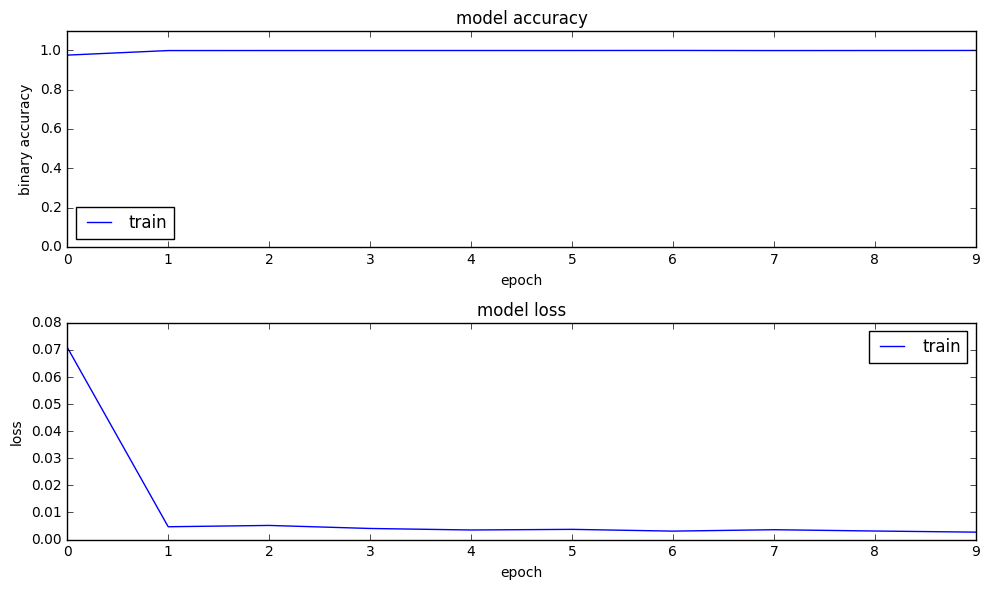

In [28]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax1.plot(np.array(range(10)),history.history['binary_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('binary accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0,1.1)
ax1.legend(['train'], loc=0)
# summarize history for loss
ax2 = fig.add_subplot(212)
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper right')
plt.tight_layout()
plt.show()

### Results
The model appears to have learned the features in the data that enable it to detect the objective audio event with **almost 100% accuracy; this is not that unexpected.**

Next lets test the accuracy on **unseen data** to see how well we have done.

As far as tuning the model definition a possible step may be to see if simplifying the layers will still provide a similar result.

# Test on an Unseen Data Set
The ```161225-002_16bit-part-0.wav-fft.csv``` data was not used in the training or validation of the model. This data contains positive and negative labels.

In [24]:
%%time
fft_compressed_file = fft_directory+'161225-002_16bit-part-0.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-002_16bit-part-0.wav-fft.csv.gz-response.csv'

fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

if K.image_dim_ordering() == 'th':
    X = fft_data.values.reshape(fft_data.shape[0], 1, sample_length)
else:
    X = fft_data.values.reshape(fft_data.shape[0], sample_length, 1)

X = X.astype('float32')

print(X.shape[0], 'test samples')

Y_true = np.array(fft_response)

# score = model.evaluate(X, Y_true, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
y_true = fft_response
y_pred = model.predict_classes(X)
print_metrics(y_true, y_pred)

10253 test samples
10253/10253 [==============================] - 93s    
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00      9794
    Class 1       0.98      1.00      0.99       459

avg / total       1.00      1.00      1.00     10253

[[9785    9]
 [   0  459]]
CPU times: user 12min 49s, sys: 22.4 s, total: 13min 12s
Wall time: 1min 46s


### Lets examine the mis-classified samples

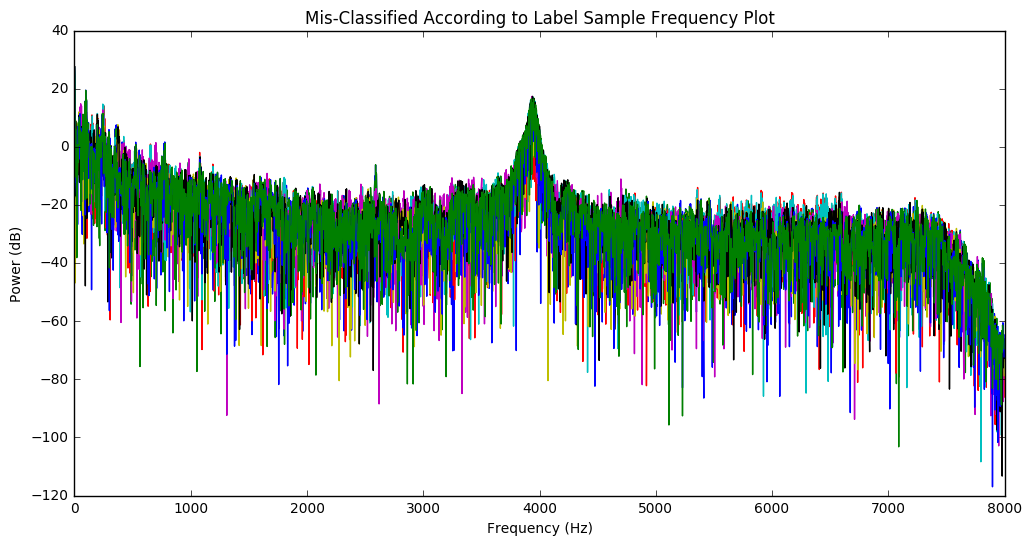

In [25]:
import matplotlib.pyplot as plt

miss_classified = fft_data[y_true != y_pred[:,0]]
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(miss_classified)):
    ax.plot(np.arange(0,8000,8000/2400.0),miss_classified.iloc[i].tolist(), label=y_true[i])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')
ax.set_title('Mis-Classified According to Label Sample Frequency Plot')
plt.show();

The combined plot above shows that the classifier correctly predicted the correct class. It appears that the labels for the sample are incorrect.

Lets look at where in the sequence of FFT samples the mis-labeling occured.

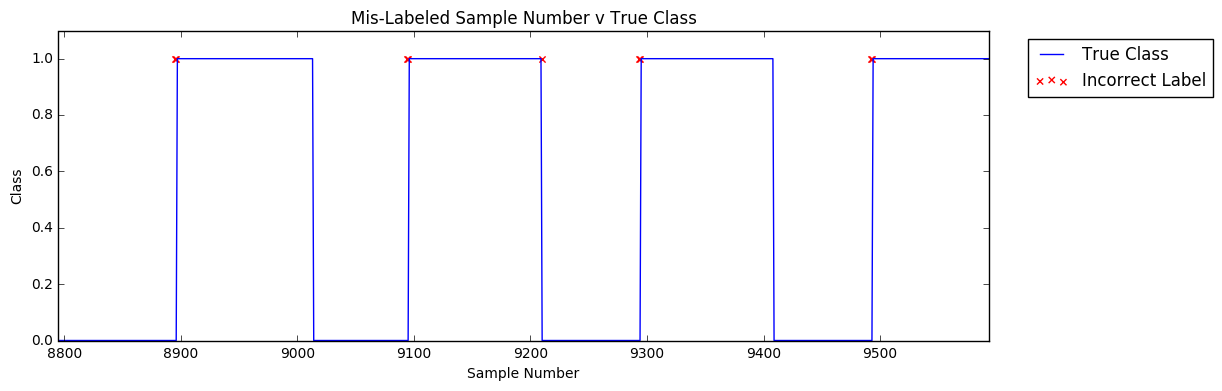

In [26]:
pred_df = pd.DataFrame(y_true != y_pred[:,0])
miss_classified_samples = pred_df.loc[pred_df.response == True]
x_limits = (miss_classified_samples.index[0]-100,miss_classified_samples.index[-1]+100)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(y_true,label='True Class')
ax.scatter(x=miss_classified_samples.index,y=miss_classified_samples.response,label='Incorrect Label', color='r', marker='x')
ax.set_xlim(x_limits)
ax.set_ylim(0,1.1)
ax.legend(bbox_to_anchor=(1.25, 1))
ax.set_xlabel('Sample Number')
ax.set_ylabel('Class')
ax.set_title('Mis-Labeled Sample Number v True Class')
plt.show();

You can see from the plot above that the labeling errors are at the rising and falling edges of the possitive class ('beep'). Further work on the auto-labeling could be done to correct this.

### Results
The model has performed very well on this unseen data set. If the response labeling were fixed the accuracy for this classifier is **100%** on the data used for training the model.

# Test on an Unseen Data Set with All Negative Labels
The ```161225-000_16bit-part-0.wav-fft.csv``` data was not used in training the model and all observations have negative response labels.

In [27]:
fft_compressed_file = fft_directory+'161225-000_16bit-part-0.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-000_16bit-part-0.wav-fft.csv.gz-response.csv'

fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

if K.image_dim_ordering() == 'th':
    X = fft_data.values.reshape(fft_data.shape[0], 1, sample_length)
else:
    X = fft_data.values.reshape(fft_data.shape[0], sample_length, 1)

X = X.astype('float32')

print(X.shape[0], 'test samples')

Y_true = np.array(fft_response)

# score = model.evaluate(X, Y_true, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
y_true = fft_response
y_pred = model.predict_classes(X)
print_metrics(y_true, y_pred)

11970 test samples
11970/11970 [==============================] - 105s   
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     11970

avg / total       1.00      1.00      1.00     11970

[[11970]]


### Results
The model has performed very well on this unseen data set with **100% accuracy**.

# Utility for Loading a Saved Model

In [1]:
from keras.models import load_model
import tensorflow as tf
tf.python.control_flow_ops = tf

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('audio_detection.h5')

Using TensorFlow backend.


In [2]:
model


# Test all Remaining Data Sets

In [31]:
%%time
for fft_compressed_file in fft_compressed_files:
    
    fft_compressed_file = '{0}/{1}'.format(fft_directory,fft_compressed_file)
    fft_response_file = '{0}-response.csv'.format(fft_compressed_file)

    fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
    fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

    if K.image_dim_ordering() == 'th':
        X = fft_data.values.reshape(fft_data.shape[0], 1, sample_length)
    else:
        X = fft_data.values.reshape(fft_data.shape[0], sample_length, 1)

    X = X.astype('float32')

    print(X.shape[0], 'test samples')

    y_true = fft_response
    y_pred = model.predict_classes(X)
    print('\n'+fft_compressed_file)
    print_metrics(y_true, y_pred)

11970 test samples
11970/11970 [==============================] - 101s   

/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft//161225-000_16bit-part-0.wav-fft.csv.gz
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     11970

avg / total       1.00      1.00      1.00     11970

[[11970]]
11970 test samples
11970/11970 [==============================] - 101s   

/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft//161225-000_16bit-part-1.wav-fft.csv.gz
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     11970

avg / total       1.00      1.00      1.00     11970

[[11970]]
11970 test samples
11970/11970 [==============================] - 103s   

/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft//161225-000_16bit-part-2.wav-fft.csv.gz
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     11970

avg / total       1.

/Volumes/ThorsHammer/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


11970 test samples
11970/11970 [==============================] - 100s   

/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft//161225-006_16bit-part-1.wav-fft.csv.gz
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     11510
    Class 1       0.97      1.00      0.99       460

avg / total       1.00      1.00      1.00     11970

[[11496    14]
 [    0   460]]
7535 test samples
7535/7535 [==============================] - 62s    

/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft//161225-006_16bit-part-2.wav-fft.csv.gz
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00      7128
    Class 1       0.97      0.99      0.98       407

avg / total       1.00      1.00      1.00      7535

[[7115   13]
 [   5  402]]
CPU times: user 5h 47min 4s, sys: 9min 43s, total: 5h 56min 47s
Wall time: 45min 1s
